### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/alabama/2023_06_02_18_00_54/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
intervention_person_time.csv     transition_count.csv
intervention_person_time.hdf     transition_count.hdf
ldlc_medication_person_time.csv  ylds.csv
ldlc_medication_person_time.hdf  ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/alabama/2023_06_02_18_00_54/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,1.0
1,1,female,2023,acute_ischemic_stroke,deaths,29,lifestyle_100,25_to_29,1.0
2,2,female,2023,acute_ischemic_stroke,deaths,29,lifestyle_50,25_to_29,1.0
3,3,female,2023,acute_ischemic_stroke,deaths,29,outreach_100,25_to_29,1.0
4,4,female,2023,acute_ischemic_stroke,deaths,29,outreach_50,25_to_29,1.0


In [6]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [7]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

696659390.1054071

In [9]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
person_time_test.value.sum()

696659390.1054072

### Total DALYs by Year

In [10]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year','scenario','location']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year','scenario','location']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,scenario,yll,yld,daly
0,female,25_to_29,29,2023,baseline,1905.328365,48.445056,1953.773422
1,female,25_to_29,29,2023,lifestyle_100,1905.328365,48.445056,1953.773422
2,female,25_to_29,29,2023,lifestyle_50,1905.328365,48.445056,1953.773422
3,female,25_to_29,29,2023,outreach_100,1905.328365,48.445056,1953.773422
4,female,25_to_29,29,2023,outreach_50,1905.328365,48.445056,1953.773422


In [11]:
daly_sum = (daly_total
                .groupby(['year','scenario','location'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,scenario,mean,2.5%,97.5%
0,2023,baseline,6105.487633,841.93454,12841.183466
1,2023,lifestyle_100,6105.207463,841.93454,12841.177469
2,2023,lifestyle_50,6105.361903,841.93454,12841.183466
3,2023,outreach_100,6101.881375,841.93454,12841.160512
4,2023,outreach_50,6103.240807,841.93454,12841.184372


### All Cause Mortality Graphs

In [13]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,4.4375,0.0,21.1
1,25_to_29,female,2023,lifestyle_100,4.4375,0.0,21.1
2,25_to_29,female,2023,lifestyle_50,4.4375,0.0,21.1
3,25_to_29,female,2023,outreach_100,4.4375,0.0,21.1
4,25_to_29,female,2023,outreach_50,4.4375,0.0,21.1


#### All Cause Mortality Graph with Rate

In [15]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw','scenario','location']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,scenario,ptvalue
0,25_to_29,female,2023,29,baseline,27022.28063
1,25_to_29,female,2023,29,lifestyle_100,27022.28063
2,25_to_29,female,2023,29,lifestyle_50,27022.28063
3,25_to_29,female,2023,29,outreach_100,27022.28063
4,25_to_29,female,2023,29,outreach_50,27022.28063


In [16]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw','scenario','location']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.001324,0.00066,0.002398
1,25_to_29,female,2023,lifestyle_100,0.001324,0.00066,0.002398
2,25_to_29,female,2023,lifestyle_50,0.001324,0.00066,0.002398
3,25_to_29,female,2023,outreach_100,0.001324,0.00066,0.002398
4,25_to_29,female,2023,outreach_50,0.001324,0.00066,0.002398


In [19]:
result_summary_allage = (results_rate
                      .groupby(['sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allage.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,0.049137,0.000992,0.294486
1,female,2023,lifestyle_100,0.049130,0.000992,0.294486
2,female,2023,lifestyle_50,0.049130,0.000992,0.294486
3,female,2023,outreach_100,0.049121,0.000992,0.294486
4,female,2023,outreach_50,0.049124,0.000992,0.294486


In [21]:
result_summary_allsex = (results_rate
                      .groupby(['age', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allsex.head()

,age,year,scenario,mean,2.5%,97.5%
0,25_to_29,2023,baseline,0.001901,0.000687,0.002958
1,25_to_29,2023,lifestyle_100,0.001901,0.000687,0.002958
2,25_to_29,2023,lifestyle_50,0.001901,0.000687,0.002958
3,25_to_29,2023,outreach_100,0.001899,0.000687,0.002938
4,25_to_29,2023,outreach_50,0.001901,0.000687,0.002958


### Cause Specific Mortality Graphs
#### Acute Stroke

In [23]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause','scenario','location'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,scenario,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,baseline,0.1,0.0,0.775
1,1,25_to_29,female,2023,acute_ischemic_stroke,lifestyle_100,0.1,0.0,0.775
2,2,25_to_29,female,2023,acute_ischemic_stroke,lifestyle_50,0.1,0.0,0.775
3,3,25_to_29,female,2023,acute_ischemic_stroke,outreach_100,0.1,0.0,0.775
4,4,25_to_29,female,2023,acute_ischemic_stroke,outreach_50,0.1,0.0,0.775


In [24]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause','scenario','location']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,scenario,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,baseline,1.0
1,1,25_to_29,female,2023,29,acute_ischemic_stroke,lifestyle_100,1.0
2,2,25_to_29,female,2023,29,acute_ischemic_stroke,lifestyle_50,1.0
3,3,25_to_29,female,2023,29,acute_ischemic_stroke,outreach_100,1.0
4,4,25_to_29,female,2023,29,acute_ischemic_stroke,outreach_50,1.0


In [25]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000004,0.0,0.000029
1,25_to_29,female,2023,lifestyle_100,0.000004,0.0,0.000029
2,25_to_29,female,2023,lifestyle_50,0.000004,0.0,0.000029
3,25_to_29,female,2023,outreach_100,0.000004,0.0,0.000029
4,25_to_29,female,2023,outreach_50,0.000004,0.0,0.000029


#### Chronic Stroke

In [27]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000004,0.000000,0.000029
1,25_to_29,female,2023,lifestyle_100,0.000004,0.000000,0.000029
2,25_to_29,female,2023,lifestyle_50,0.000004,0.000000,0.000029
3,25_to_29,female,2023,outreach_100,0.000004,0.000000,0.000029
...,...,...,...,...,...,...,...
3776,95_plus,male,2040,outreach_100,0.008614,0.004511,0.013023
3777,95_plus,male,2040,outreach_50,0.008528,0.005091,0.012105
3778,95_plus,male,2040,polypill_100,0.009368,0.006595,0.015261
3779,95_plus,male,2040,polypill_50,0.008861,0.006462,0.013451


### CSMR for All Stroke

In [29]:
stroke_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['chronic_ischemic_stroke','acute_ischemic_stroke']))].reset_index()
stroke_rate = stroke_rate.groupby(['age', 'sex', 'year','scenario','input_draw','location']).value.sum().reset_index()
stroke_rate = stroke_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw', 'scenario','location'])
stroke_rate['mean_rate'] = stroke_rate['value'] / stroke_rate['ptvalue']
stroke_rate_summ = (stroke_rate
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000007,0.0,0.000037
1,25_to_29,female,2023,lifestyle_100,0.000007,0.0,0.000037
2,25_to_29,female,2023,lifestyle_50,0.000007,0.0,0.000037
3,25_to_29,female,2023,outreach_100,0.000007,0.0,0.000037
4,25_to_29,female,2023,outreach_50,0.000007,0.0,0.000037


### CSMR for All IHD 

In [31]:
IHD_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','heart_failure_from_ischemic_heart_disease','heart_failure_residual','post_myocardial_infarction']))].reset_index()
IHD_rate = IHD_rate.groupby(['age', 'sex', 'year','scenario','input_draw','location']).value.sum().reset_index()
IHD_rate = IHD_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw', 'scenario','location'])
IHD_rate['mean_rate'] = IHD_rate['value'] / IHD_rate['ptvalue']
IHD_rate_summ = (IHD_rate
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000892,0.000332,0.001841
1,25_to_29,female,2023,lifestyle_100,0.000892,0.000332,0.001841
2,25_to_29,female,2023,lifestyle_50,0.000892,0.000332,0.001841
3,25_to_29,female,2023,outreach_100,0.000892,0.000332,0.001841
4,25_to_29,female,2023,outreach_50,0.000892,0.000332,0.001841


#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [34]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw', 'scenario','location'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000164,0.0,0.000907
1,25_to_29,female,2023,lifestyle_100,0.000164,0.0,0.000907
2,25_to_29,female,2023,lifestyle_50,0.000164,0.0,0.000907
3,25_to_29,female,2023,outreach_100,0.000164,0.0,0.000907
4,25_to_29,female,2023,outreach_50,0.000164,0.0,0.000907


#### Post Myocaridal Infarction

In [37]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000146,0.000037,0.000397
1,25_to_29,female,2023,lifestyle_100,0.000146,0.000037,0.000397
2,25_to_29,female,2023,lifestyle_50,0.000146,0.000037,0.000397
3,25_to_29,female,2023,outreach_100,0.000146,0.000037,0.000397
4,25_to_29,female,2023,outreach_50,0.000146,0.000037,0.000397


#### Heart Failure

In [41]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw','scenario','location'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000209,0.0,0.000603
1,25_to_29,female,2023,lifestyle_100,0.000209,0.0,0.000603
2,25_to_29,female,2023,lifestyle_50,0.000209,0.0,0.000603
3,25_to_29,female,2023,outreach_100,0.000209,0.0,0.000603
4,25_to_29,female,2023,outreach_50,0.000209,0.0,0.000603


### Excess Mortality rate

#### Post Myocardial Infarction

In [45]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw','scenario','location']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.06022,0.019435,0.160457
1,25_to_29,female,2023,lifestyle_100,0.06022,0.019435,0.160457
2,25_to_29,female,2023,lifestyle_50,0.06022,0.019435,0.160457
3,25_to_29,female,2023,outreach_100,0.06022,0.019435,0.160457
4,25_to_29,female,2023,outreach_50,0.06022,0.019435,0.160457


#### Heart Failure EMR

In [47]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw','scenario','location'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.61457,0.0,3.56583
1,25_to_29,female,2023,lifestyle_100,0.61457,0.0,3.56583
2,25_to_29,female,2023,lifestyle_50,0.61457,0.0,3.56583
3,25_to_29,female,2023,outreach_100,0.61457,0.0,3.56583
4,25_to_29,female,2023,outreach_50,0.61457,0.0,3.56583


##### Looks weird check with artifact values

### All IHD EMR

In [49]:
per_time_IHD = per_time_state.loc[(per_time_state['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction"]))].reset_index()
per_time_IHD = per_time_IHD.groupby(['age','sex','year','input_draw','scenario','location']).ptvalue.sum().reset_index()
IHD_emr = death_rate_cause.loc[(death_rate_cause['cause'].isin(['heart_failure_from_ischemic_heart_disease','heart_failure_residual','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','acute_myocardial_infarction']))].reset_index()
IHD_emr = IHD_emr.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
IHD_emr = IHD_emr.merge(per_time_IHD[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw','scenario','location'])
IHD_emr['mean_rate'] = IHD_emr['value'] / IHD_emr['ptvalue']
IHD_emr_summ = (IHD_emr
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_emr_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.135269,0.047056,0.212
1,25_to_29,female,2023,lifestyle_100,0.135269,0.047056,0.212
2,25_to_29,female,2023,lifestyle_50,0.135269,0.047056,0.212
3,25_to_29,female,2023,outreach_100,0.135269,0.047056,0.212
4,25_to_29,female,2023,outreach_50,0.135269,0.047056,0.212


### All Stroke EMR

In [51]:
per_time_stroke = per_time_state.loc[(per_time_state['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke"]))].reset_index()
per_time_stroke = per_time_stroke.groupby(['age','sex','year','input_draw','scenario','location']).ptvalue.sum().reset_index()
stroke_emr = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_ischemic_stroke','chronic_ischemic_stroke']))].reset_index()
stroke_emr = stroke_emr.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
stroke_emr = stroke_emr.merge(per_time_stroke[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw','scenario','location'])
stroke_emr['mean_rate'] = stroke_emr['value'] / stroke_emr['ptvalue']
stroke_emr_summ = (stroke_emr
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_emr_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.001138,0.0,0.006439
1,25_to_29,female,2023,lifestyle_100,0.001138,0.0,0.006439
2,25_to_29,female,2023,lifestyle_50,0.001138,0.0,0.006439
3,25_to_29,female,2023,outreach_100,0.001138,0.0,0.006439
4,25_to_29,female,2023,outreach_50,0.001138,0.0,0.006439


### Prevalence 

#### Chronic + Acute Stroke

In [53]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year','scenario','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.00003,0.0,0.000176
1,25_to_29,female,2023,lifestyle_100,0.00003,0.0,0.000176
2,25_to_29,female,2023,lifestyle_50,0.00003,0.0,0.000176
3,25_to_29,female,2023,outreach_100,0.00003,0.0,0.000176
4,25_to_29,female,2023,outreach_50,0.00003,0.0,0.000176


In [55]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year','scenario','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

#### Myocardial Infarction

In [57]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw','scenario','location'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year','scenario','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000114,0.000001,0.000362
1,25_to_29,female,2023,lifestyle_100,0.000114,0.000001,0.000362
2,25_to_29,female,2023,lifestyle_50,0.000114,0.000001,0.000362
3,25_to_29,female,2023,outreach_100,0.000114,0.000001,0.000362
4,25_to_29,female,2023,outreach_50,0.000114,0.000001,0.000362


In [59]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year','scenario','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.002813,0.000986,0.006968
1,25_to_29,female,2023,lifestyle_100,0.002813,0.000986,0.006968
2,25_to_29,female,2023,lifestyle_50,0.002813,0.000986,0.006968
3,25_to_29,female,2023,outreach_100,0.002813,0.000986,0.006968
4,25_to_29,female,2023,outreach_50,0.002813,0.000986,0.006968


### Prevalence of Heart Failure

In [64]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw','scenario','location'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year','scenario','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.001249,0.000136,0.002989
1,25_to_29,female,2023,lifestyle_100,0.001249,0.000136,0.002989
2,25_to_29,female,2023,lifestyle_50,0.001249,0.000136,0.002989
3,25_to_29,female,2023,outreach_100,0.001249,0.000136,0.002989
4,25_to_29,female,2023,outreach_50,0.001249,0.000136,0.002989


### Incidence of First Time Acute Ischemic Stroke

In [67]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition','scenario','location'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,scenario,mean,2.5%,97.5%
0,70,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,baseline,7.8,0.0,38.7
1,71,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,lifestyle_100,7.8,0.0,38.7
2,72,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,lifestyle_50,7.8,0.0,38.7
3,73,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,outreach_100,7.8,0.0,38.7
4,74,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,outreach_50,7.8,0.0,38.7


In [68]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,scenario,ptvalue
0,560,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,baseline,26791.457906
1,561,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,lifestyle_100,26791.457906
2,562,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,lifestyle_50,26791.457906
3,563,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,outreach_100,26791.457906
4,564,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,outreach_50,26791.457906


In [69]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw','scenario','location']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year','scenario','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.00029,0.0,0.001435
1,25_to_29,female,2023,lifestyle_100,0.00029,0.0,0.001435
2,25_to_29,female,2023,lifestyle_50,0.00029,0.0,0.001435
3,25_to_29,female,2023,outreach_100,0.00029,0.0,0.001435
4,25_to_29,female,2023,outreach_50,0.00029,0.0,0.001435


### Incidence of Acute Myocardial Infraction 

In [73]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw','scenario','location']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%    97.5%
age      sex    year scenario                                  
25_to_29 female 2023 baseline       0.001489  0.000025  0.00505
                     lifestyle_100  0.001489  0.000025  0.00505
                     lifestyle_50   0.001489  0.000025  0.00505
                     outreach_100   0.001489  0.000025  0.00505
                     outreach_50    0.001489  0.000025  0.00505

### Artifacts

In [82]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/

alabama-BAD-PAFS.hdf  alabama.hdf


In [83]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [84]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [85]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'healthcare_entity.outpatient_visits.outpatient_envelope',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.acute_myocardial_infarction_and_heart_failure.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.heart_failure_from_ischemic_heart_disease.prevalence',
 '

In [86]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [ ]:
locations = state_person_time.location.unique()

In [87]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in locations: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [88]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [89]:
result_summary_allyears = (results_rate.loc[results_rate.scenario=='baseline']
                      .groupby(['age', 'sex','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001269,0.000547,0.002511
1,25_to_29,male,0.002367,0.001593,0.003422
2,30_to_34,female,0.001535,0.000906,0.002898
3,30_to_34,male,0.002560,0.001726,0.004128
4,35_to_39,female,0.001788,0.001190,0.002369


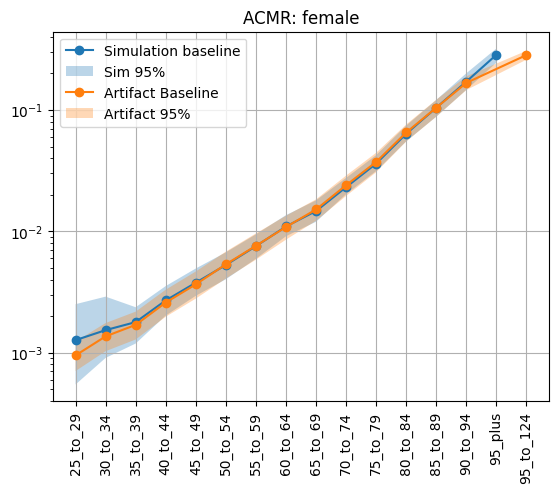

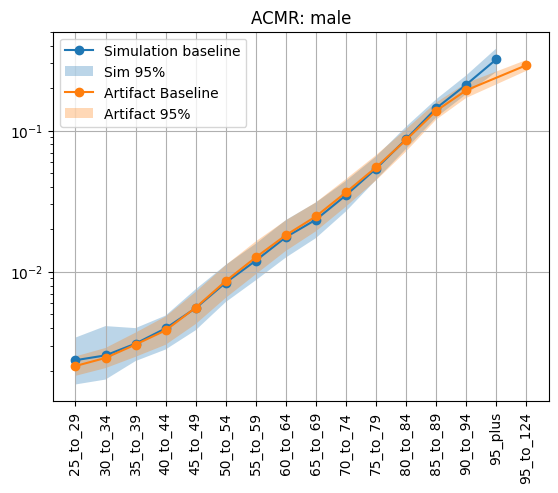

In [90]:
for location in result_summary_allyears.location.unique():
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.location==location) & (result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.location==location) & (art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [91]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [92]:
acute_rate_sum_allyear = (acute_rate_2.loc[acute_rate_2.scenario=='baseline']
                      .groupby(['age', 'sex','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [93]:
chronic_rate_allyear = (chronic_rate.loc[chronic_rate.scenario=='baseline']
                      .groupby(['age', 'sex','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [94]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [95]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex','location'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000008,0.0,0.000078
1,25_to_29,male,0.000007,0.0,0.000076
2,30_to_34,female,0.000016,0.0,0.000200
3,30_to_34,male,0.000009,0.0,0.000076
4,35_to_39,female,0.000006,0.0,0.000039


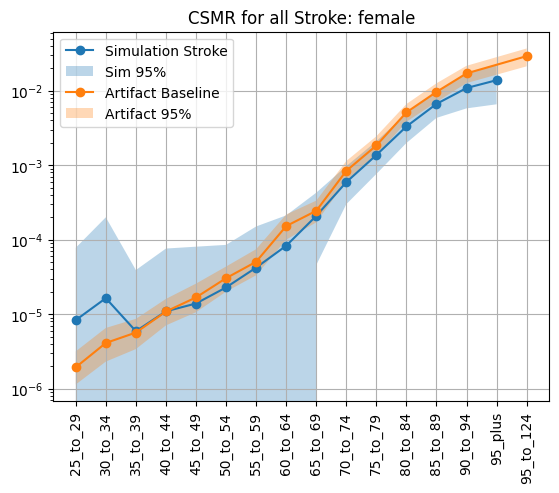

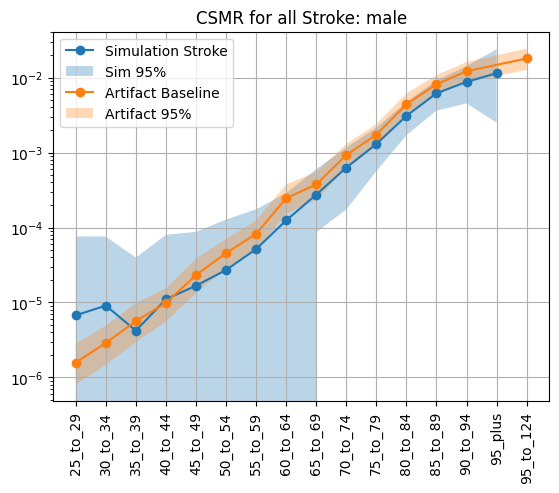

In [96]:
for location in acute_rate_sum_allyear.location.unique():
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.location==location) & (total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.location==location) & (art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        plt.show()

#### IHD and HF Combined

In [97]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000546,0.000412,0.000710,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000652,0.000483,0.000838,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000746,0.000545,0.000978,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000804,0.000611,0.001051,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.001383,0.001112,0.001699,Alabama,cause_specific_mortality_rate,45_to_49


In [99]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw','location']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue','location']], on=['age','sex','year','input_draw','location'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.006047,0.001684,0.013751
1,25_to_29,male,0.007025,0.003184,0.011656
2,30_to_34,female,0.005654,0.002149,0.014429
3,30_to_34,male,0.007701,0.003913,0.018843
...,...,...,...,...,...
26,90_to_94,female,0.731929,0.571053,0.964458
27,90_to_94,male,1.155180,0.909914,1.532480
28,95_plus,female,1.008132,0.739792,1.354061
29,95_plus,male,1.586301,1.155183,2.132875


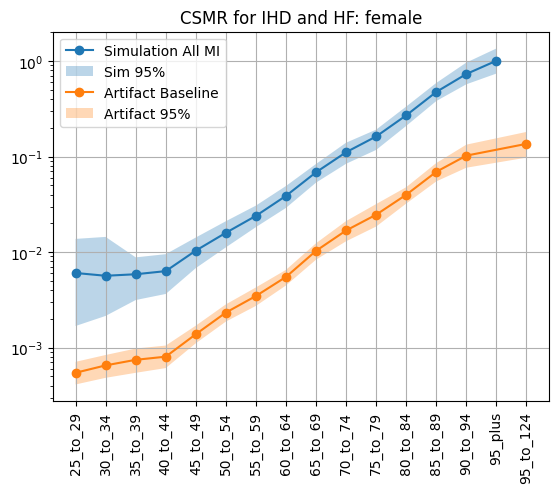

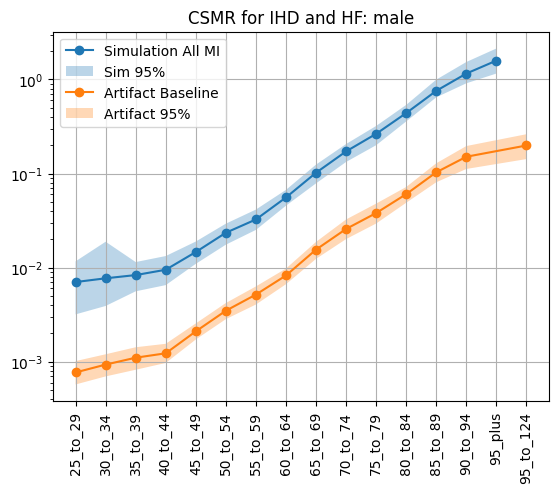

In [100]:
for location in IHD_HF_CSMR_allyear.location.unique():
    for sex in IHD_HF_CSMR_allyear.sex.unique():
        plt.figure() 
        subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.location==location) & (IHD_HF_CSMR_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata3 = art_csmr2.loc[(art_csmr2.location==location) & (art_csmr2.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for IHD and HF: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [101]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [102]:
tran_rate_sum_allyear = (tran_rate.loc[tran_rate.scenario=='baseline']
                 .groupby(['age', 'sex', 'year','location'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,year,50%,2.5%,97.5%
0,25_to_29,female,2023,0.000111,0.0,0.001435
1,25_to_29,female,2024,0.000038,0.0,0.001412
2,25_to_29,female,2025,0.000038,0.0,0.001254
3,25_to_29,female,2026,0.000076,0.0,0.001410
4,25_to_29,female,2027,0.000096,0.0,0.001802


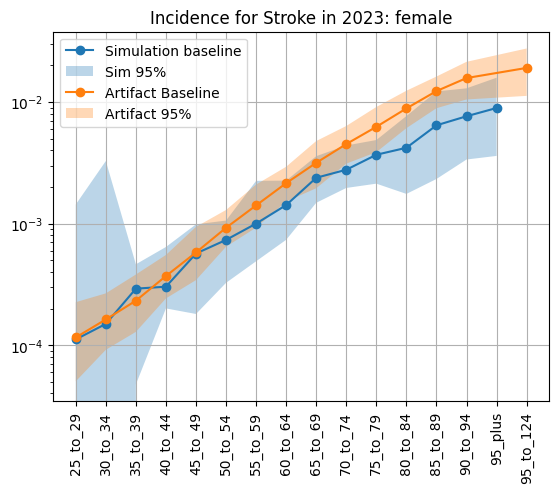

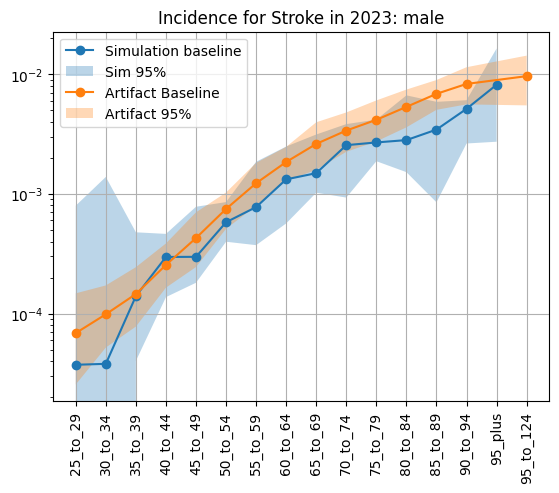

In [103]:
for location in tran_rate_sum_allyear.location.unique():
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.location==location) & (tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
        plt.plot(subdata['age'], subdata['50%'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.location==location) & (art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke in 2023: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

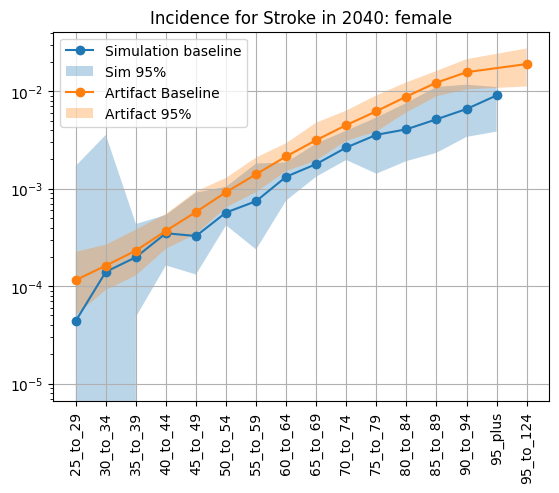

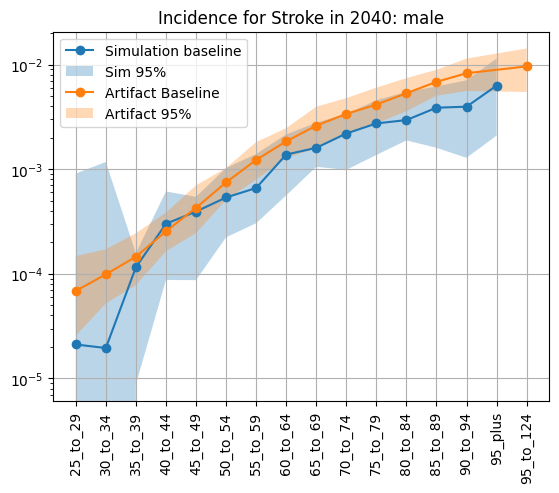

In [104]:
for location in tran_rate_sum_allyear.location.unique():
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.location==location) & (tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2040)]
        plt.plot(subdata['age'], subdata['50%'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.location==location) & (art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke in 2040: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [106]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000453,0.000285,0.000617,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000512,0.000347,0.000685,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000428,0.000297,0.000583,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000541,0.000415,0.000692,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000853,0.000652,0.001114,Alabama,incidence_rate,45_to_49


In [107]:
groupby_cols2 = ['age', 'sex', 'input_draw','location']
tran_rate_MI_all = tran_rate_MI.loc[tran_rate_MI.scenario=='baseline'].groupby(groupby_cols2).sum() / per_time_sus_MI.loc[per_time_sus_MI.scenario=='baseline'].groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 female  0.001260  0.000715  0.000026  0.003383
         male    0.000796  0.000660  0.000032  0.001892
30_to_34 female  0.001101  0.000451  0.000103  0.005032
         male    0.001211  0.000515  0.000239  0.005209
35_to_39 female  0.000575  0.000501  0.000289  0.001135

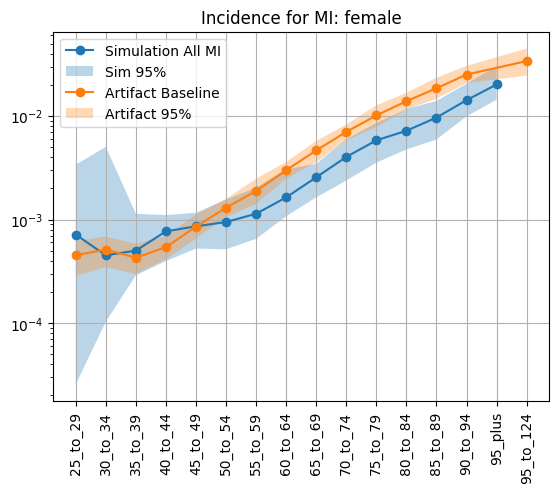

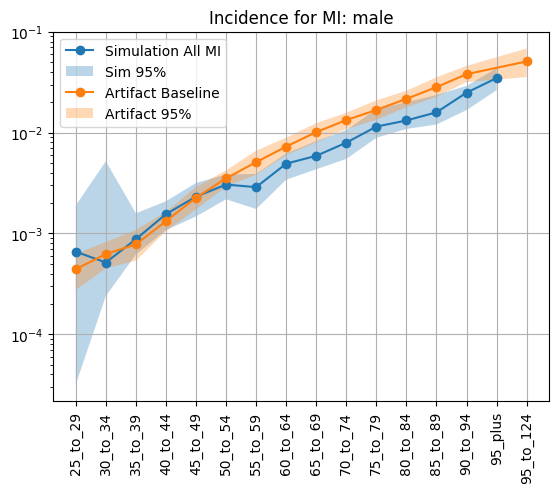

In [108]:
%matplotlib inline
for location in tran_MI_summ_allyear.index.get_level_values('location').unique():
    for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
        plt.figure() 
        subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('location')==location)(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
        plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
        plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.location==location) & (art_inc_acute_MI.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'Incidence for MI: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        plt.show()

### Incidence Rates for Heart Failure IHD

In [109]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000057,0.000041,0.000075,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000081,0.000060,0.000104,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000089,0.000056,0.000130,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000185,0.000138,0.000239,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000497,0.000408,0.000590,Alabama,incidence_rate,45_to_49


In [110]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw','scenario','location']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear = tran_rate_HF_IHD_allyear.loc[tran_rate_HF_IHD_allyear.index.get_level_values('scenario')=='baseline']
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex    scenario                              
25_to_29 female baseline  0.000061  0.000041  0.000090
         male   baseline  0.000142  0.000111  0.000183
30_to_34 female baseline  0.000090  0.000041  0.000127
         male   baseline  0.000188  0.000140  0.000225
35_to_39 female baseline  0.000089  0.000067  0.000105

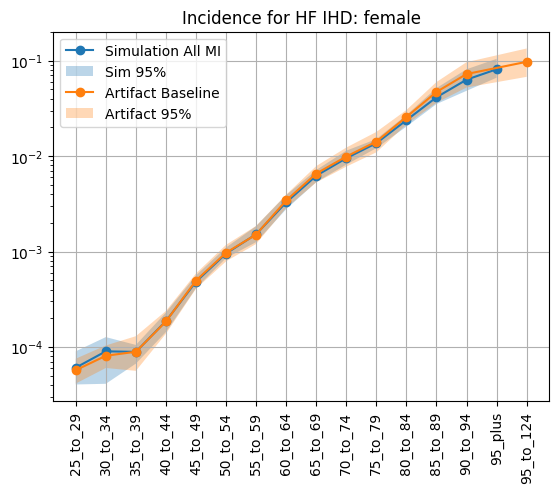

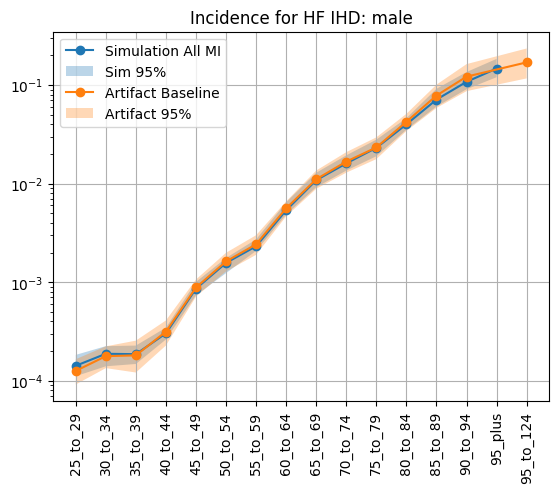

In [111]:
for location in tran_rate_HF_IHD_allyear.index.get_level_values('location').unique():
    for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
        plt.figure() 
        subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('location')==location) & (tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
        plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
        plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.location==location) & (art_inc_HF_IHD.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'Incidence for HF IHD: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [112]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000601,0.000435,0.000792,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000568,0.000423,0.000728,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000395,0.000249,0.000574,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000683,0.000509,0.000880,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.001313,0.001078,0.001558,Alabama,incidence_rate,45_to_49


In [113]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw','scenario','location']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear = tran_rate_HF_resid_allyear.loc[tran_rate_HF_resid_allyear.index.get_level_values('scenario')=='baseline']
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex    scenario                              
25_to_29 female baseline  0.000637  0.000449  0.000809
         male   baseline  0.000888  0.000755  0.001018
30_to_34 female baseline  0.000584  0.000380  0.000727
         male   baseline  0.000820  0.000647  0.000951
35_to_39 female baseline  0.000415  0.000323  0.000507

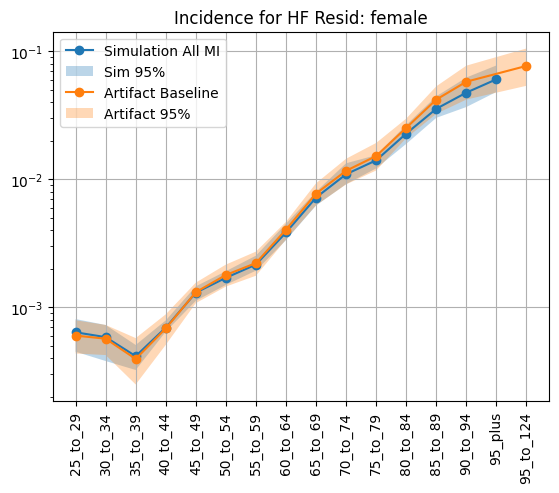

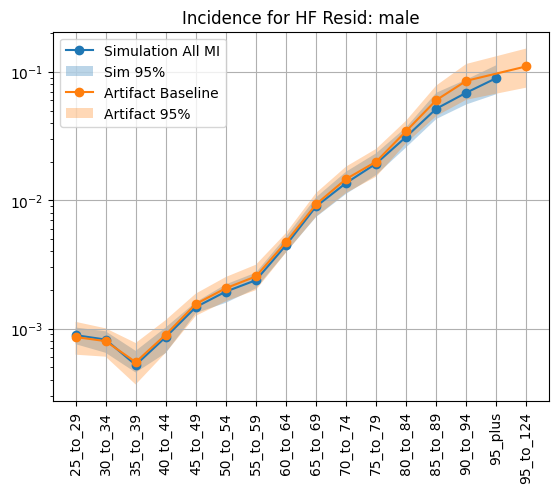

In [114]:
for location in tran_rate_HF_resid_allyear.index.get_level_values('location').unique():
    for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
        plt.figure() 
        subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('location')==location) & (tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
        plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
        plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.location==location) & (art_inc_HF_resid.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'Incidence for HF Resid: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [115]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate.loc[prev_chronic_rate.scenario=='baseline']
                 .groupby(['age', 'sex','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [116]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


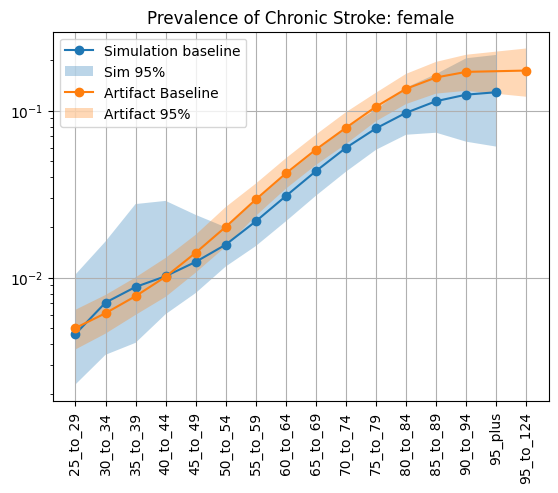

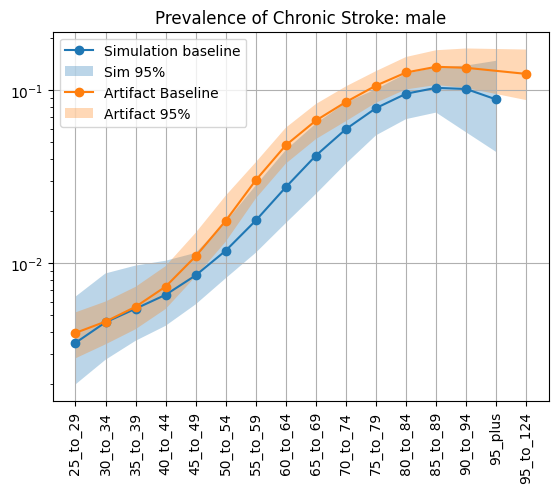

In [117]:
for location in prev_chronic_rate_sum_allyear.location.unique():
    for sex in prev_chronic_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.location==location) & (prev_chronic_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev.loc[(art_prev.location==location) & (art_prev.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Chronic Stroke: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [118]:
prev_acute_rate_sum_allyear = (prev_acute_rate.loc[prev_acute_rate.scenario=='baseline']
                 .groupby(['age', 'sex','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [119]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

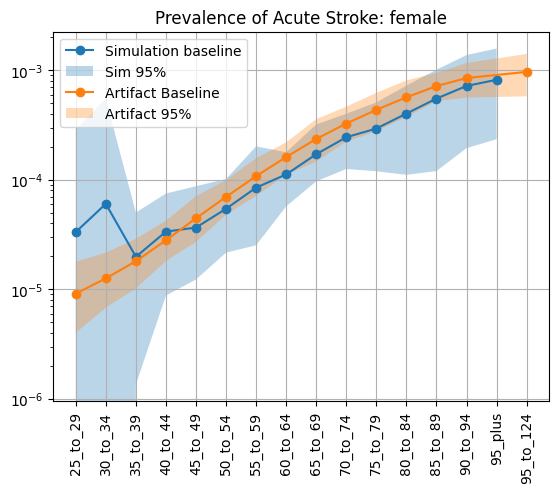

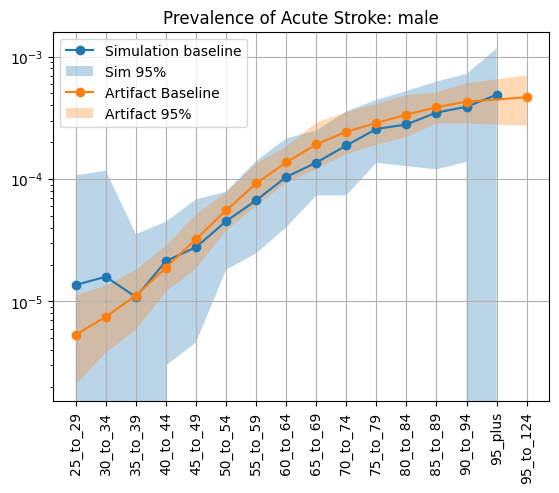

In [120]:
for location in prev_acute_rate_sum_allyear.location.unique():
    for sex in prev_acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.location==location) & (prev_acute_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev2.loc[(art_prev2.location==location) & (art_prev2.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Acute Stroke: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [121]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.002535,0.001864,0.003276,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.004010,0.003123,0.005006,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.005656,0.004445,0.007094,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.007601,0.005987,0.009411,Alabama,prevalence,45_to_49


In [122]:
prev_post_MI_sum_allyear = (prev_post_MI.loc[prev_post_MI.scenario=='baseline']
                 .groupby(['age', 'sex', 'year','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.002813,0.000986,0.006968
1,25_to_29,female,2024,0.003201,0.000757,0.008808
2,25_to_29,female,2025,0.003513,0.000468,0.010143
3,25_to_29,female,2026,0.003612,0.000353,0.010787
4,25_to_29,female,2027,0.003715,0.000295,0.011138


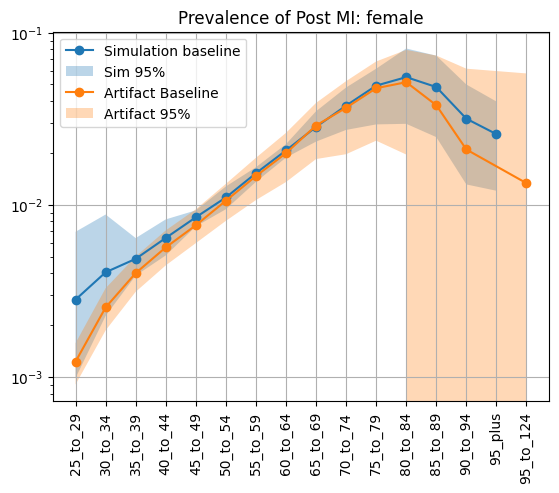

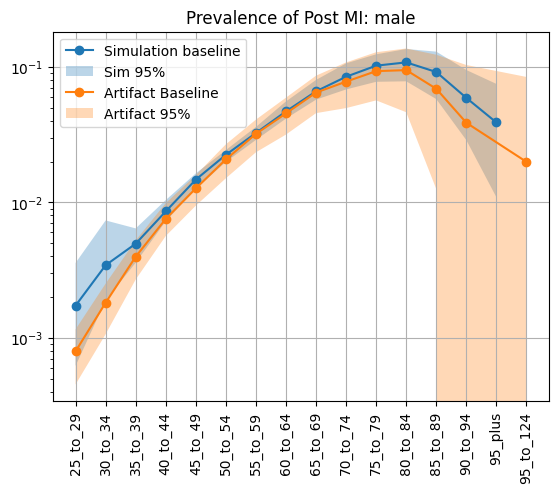

In [123]:
##Can try plotting the median 

for location in prev_post_MI_sum_allyear.location.unique():
    for sex in prev_post_MI_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.location==location) & (prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2023)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev3.loc[(art_prev3.location==location) & (art_prev3.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Post MI: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [124]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [125]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000029,0.000019,0.000040,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000036,0.000024,0.000048,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000031,0.000021,0.000042,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000037,0.000028,0.000048,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.000058,0.000044,0.000074,Alabama,prevalence,45_to_49


In [126]:
prev_acute_MI_sum_allyear = (prev_acute_MI.loc[prev_acute_MI.scenario=='baseline']
                 .groupby(['age', 'sex','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000096,0.000000,0.000282
1,25_to_29,male,0.000060,0.000000,0.000163
2,30_to_34,female,0.000084,0.000003,0.000487
3,30_to_34,male,0.000092,0.000012,0.000502
4,35_to_39,female,0.000045,0.000014,0.000097


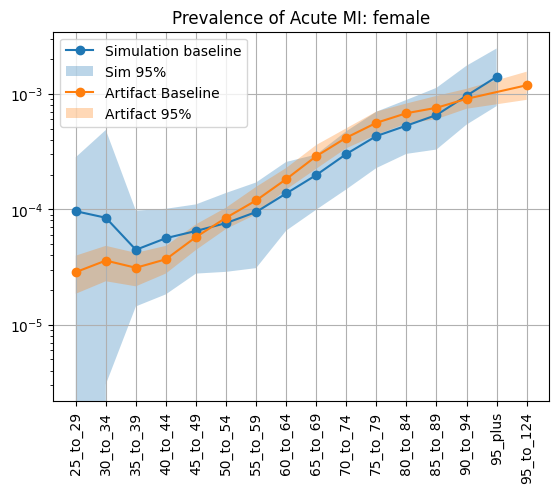

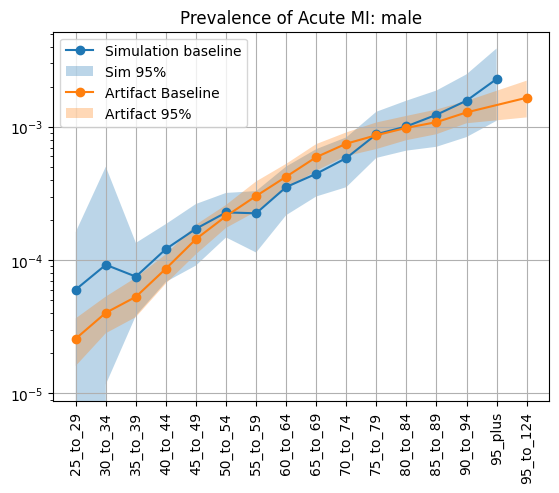

In [127]:
for location in prev_acute_MI_sum_allyear.location.unique():
    for sex in prev_acute_MI_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.location==location) & (prev_acute_MI_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev4.loc[(art_prev4.location==location) & (art_prev4.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Acute MI: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [128]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

ArtifactException: cause.heart_failure_from_ihd.prevalence should be in /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/alabama.hdf.

In [ ]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw','scenario','location'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex','scenario','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear = prev_HF_IHD_allyear.loc[prev_HF_IHD_allyear.scenario=='baseline']
prev_HF_IHD_allyear.head()

In [ ]:
for location in prev_HF_IHD_allyear.location.unique():
    for sex in prev_HF_IHD_allyear.sex.unique():
        plt.figure() 
        subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.location==location) & (prev_HF_IHD_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.location==location) & (art_prev_hf_ihd.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of HF IHD: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [129]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.002341,0.001774,0.003021,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.003290,0.002414,0.004362,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.002993,0.002267,0.003813,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.002735,0.002134,0.003475,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.004126,0.003504,0.004772,Alabama,prevalence,45_to_49


In [130]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue','location']], on=['age','sex','year','input_draw','scenario','location'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex','scenario','location'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_HF_resid_allyear = prev_HF_resid_allyear.loc[prev_HF_resid_allyear.scenario == 'baseline']
prev_HF_resid_allyear.head()

,age,sex,scenario,mean,2.5%,97.5%
0,25_to_29,female,baseline,0.002403,0.001574,0.003544
7,25_to_29,male,baseline,0.003078,0.002382,0.003964
14,30_to_34,female,baseline,0.003298,0.002156,0.004968
21,30_to_34,male,baseline,0.004225,0.003249,0.005517
28,35_to_39,female,baseline,0.003291,0.002319,0.004473


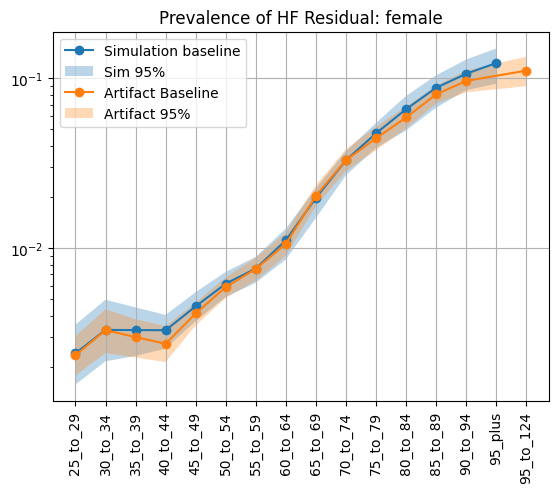

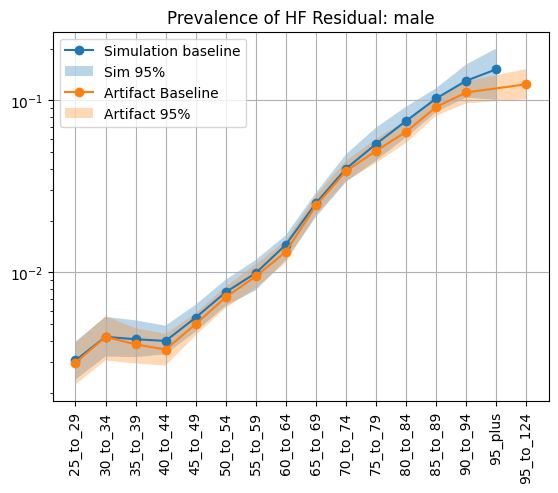

In [131]:
for location in prev_HF_resid_allyear.location.unique():
    for sex in prev_HF_resid_allyear.sex.unique():
        plt.figure() 
        subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.location==location) & (prev_HF_resid_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.location==location) & (art_prev_hf_resid.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of HF Residual: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [132]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [133]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_rate_sum_allyear=acute_rate_sum_allyear.loc[acute_rate_sum_allyear.scenario=='baseline']
acute_rate_sum_allyear.head()

,age,sex,scenario,mean,2.5%,97.5%
0,25_to_29,female,baseline,0.242764,0.0,2.587188
7,25_to_29,male,baseline,0.505275,0.0,4.348214
14,30_to_34,female,baseline,0.234001,0.0,3.032879
21,30_to_34,male,baseline,0.634011,0.0,6.250558
28,35_to_39,female,baseline,0.270387,0.0,3.261161


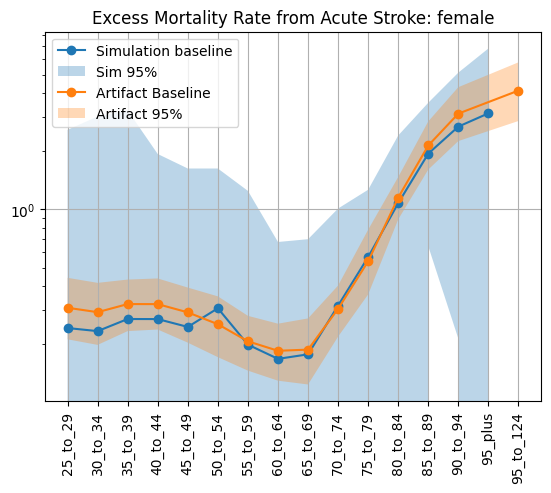

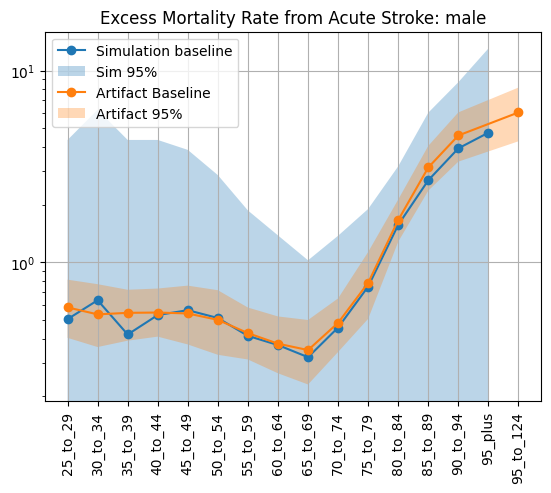

In [134]:
for location in acute_rate_sum_allyear.location.unique():
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.location==location) & (acute_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr.loc[(art_emr.location==location) & (art_emr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Acute Stroke: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [135]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [136]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_emr_allyear=chronic_rate_emr_allyear.loc[chronic_rate_emr_allyear.scenario=='baseline']
chronic_rate_emr_allyear.head()

,age,sex,scenario,mean,2.5%,97.5%
0,25_to_29,female,baseline,0.000108,0.0,0.0
7,25_to_29,male,baseline,0.000000,0.0,0.0
14,30_to_34,female,baseline,0.000073,0.0,0.0
21,30_to_34,male,baseline,0.000000,0.0,0.0
28,35_to_39,female,baseline,0.000087,0.0,0.0


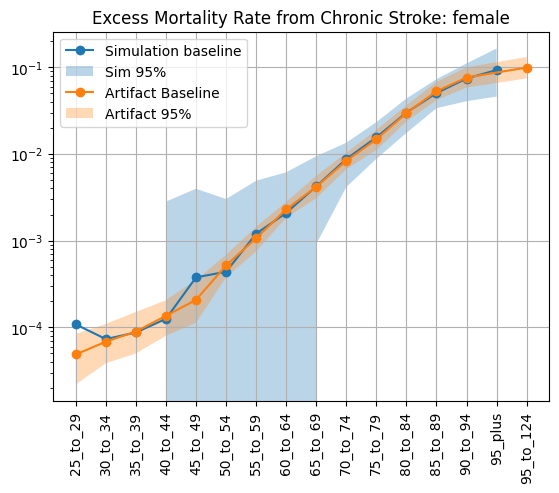

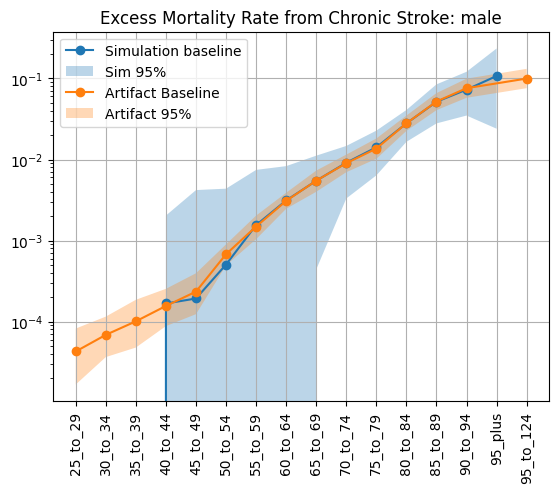

In [137]:
for location in chronic_rate_emr_allyear.location.unique():
    for sex in chronic_rate_emr_allyear.sex.unique():
        plt.figure() 
        subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.location==location) & (chronic_rate_emr_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr2.loc[(art_emr2.location==location) & (art_emr2.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [138]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [139]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw','scenario','location']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw','scenario','location']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','scenario','ptvalue','location']], on=['age','year','sex','input_draw','scenario','location'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year','scenario','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear=acute_MI_emr_rate_allyear.loc[acute_MI_emr_rate_allyear.scenario=='baseline']
acute_MI_emr_rate_allyear.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,3.235496,0.372704,7.905844
7,25_to_29,female,2024,baseline,2.845828,0.000000,6.005034
14,25_to_29,female,2025,baseline,3.166049,1.862897,5.881948
21,25_to_29,female,2026,baseline,2.837614,0.464604,4.230297
28,25_to_29,female,2027,baseline,3.592850,1.538181,7.639269


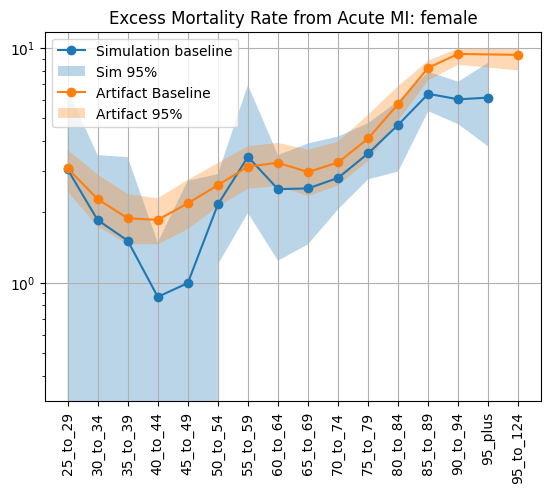

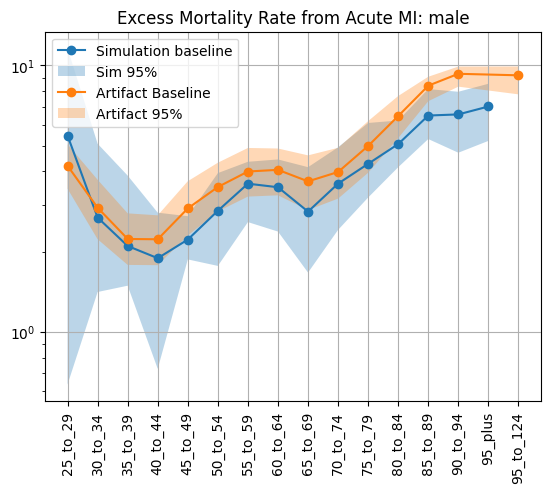

In [140]:
for location in acute_MI_emr_rate_allyear.location.unique():
    for sex in acute_MI_emr_rate_allyear.sex.unique():
        plt.figure() 
        subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.location==location) & (acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2040)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.location==location) & (art_emr_acuteMI.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Acute MI: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [141]:
post_mi_rate_emr_allyear = (post_MI_emr.loc[post_MI_emr.scenario=='baseline']
                      .groupby(['age', 'sex','location'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.052619,0.0,0.182090
1,25_to_29,male,0.049934,0.0,0.162642
2,30_to_34,female,0.024869,0.0,0.058238
3,30_to_34,male,0.028010,0.0,0.072780
4,35_to_39,female,0.017177,0.0,0.046558


In [142]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

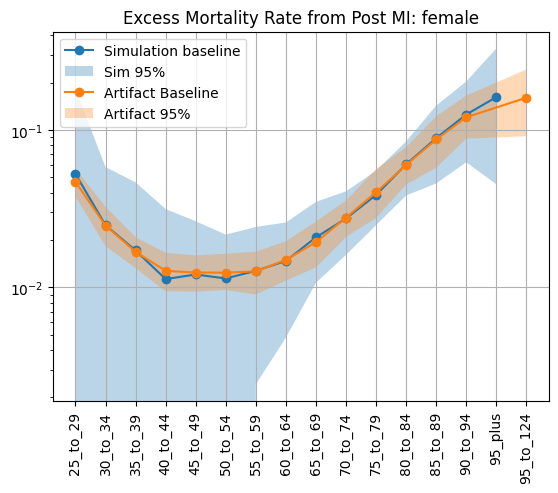

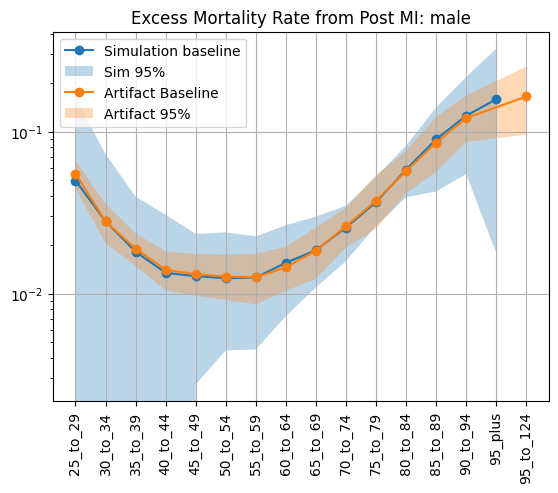

In [143]:
for location in post_mi_rate_emr_allyear.location.unique():
    for sex in post_mi_rate_emr_allyear.sex.unique():
        plt.figure() 
        subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.location==location) & (post_mi_rate_emr_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr_postMI.loc[(art_emr_postMI.location==location) & (art_emr_postMI.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Post MI: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### EMR for Heart Failure

In [144]:
art_emr_HF = load_artifact_data('cause', 'heart_failure', 'excess_mortality_rate')
art_emr_HF['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_HF.age_start,art_emr_HF.age_end)]
art_emr_HF.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.157219,0.111406,0.216535,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.136440,0.095899,0.187640,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.169535,0.122948,0.222670,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.192198,0.141037,0.254912,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.204429,0.163795,0.255060,Alabama,excess_mortality_rate,45_to_49


In [145]:
HF_emr_allyear = (HF_emr.loc[HF_emr.scenario=='baseline']
                      .groupby(['age', 'sex','location'])
                      .mean_rate.describe(percentiles=[.025,0.5, .975])
                      .filter(['mean','50%', '2.5%', '97.5%'])
                      .reset_index())


HF_emr_allyear.head()

,age,sex,mean,50%,2.5%,97.5%
0,25_to_29,female,inf,0.151462,0.0,6.522321
1,25_to_29,male,0.525490,0.187289,0.0,2.472223
2,30_to_34,female,0.414944,0.127413,0.0,2.302521
3,30_to_34,male,0.296335,0.136201,0.0,1.281987
4,35_to_39,female,0.388561,0.164464,0.0,1.962349


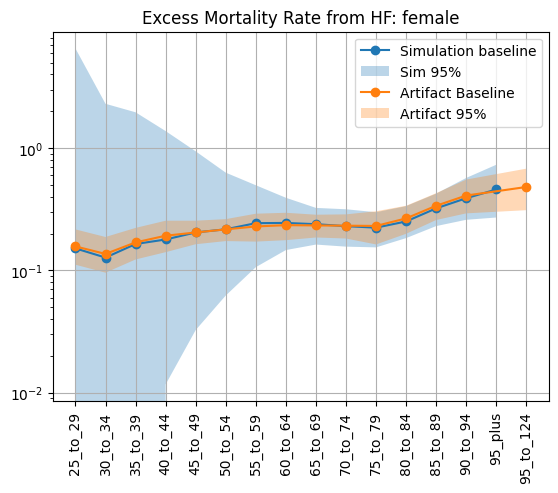

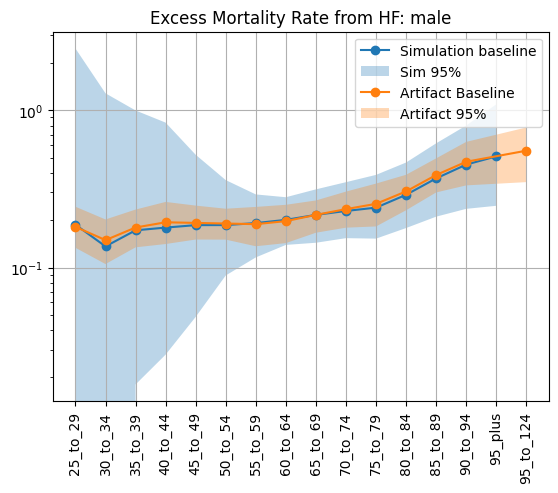

In [146]:
for location in HF_emr_allyear.location.unique():
    for sex in HF_emr_allyear.sex.unique():
        plt.figure() 
        subdata = HF_emr_allyear.loc[(HF_emr_allyear.location==location) & (HF_emr_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['50%'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr_HF.loc[(art_emr_HF.location==location) & (art_emr_HF.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from HF: {sex} and {location}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 